<a href="https://colab.research.google.com/github/yh08037/ABR-Lab-Summer-Project/blob/master/DogBreed_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Classification

## Set Tensorflow 2.0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect dataset

In [0]:
# 구글드라이브 파일 읽기 위한 연동 용 라이브러리
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 35.9MB/s 


Cropped.zip : https://drive.google.com/open?id=1b7ZeSWN0OcreoW9-53RSPlmPlNp0BUOS

In [0]:
# 실질적으로 구글드라이브에서 파일을 불러오는 방법입니다.
# 위에서 준비해두었던 공유 가능한 링크에서 'id=' 이후에 있는 문자열을 복사하여 file_id로 사용합니다.
file_id = '1b7ZeSWN0OcreoW9-53RSPlmPlNp0BUOS'
# file_id로부터 파일 객체를 생성합니다.
downloaded = drive.CreateFile({'id': file_id})
# 불러온 파일 객체를 Colab에 저장합니다.
downloaded.GetContentFile('Cropped.zip')
# 압축해제
!unzip Cropped.zip

Archive:  Cropped.zip
   creating: Cropped/
   creating: Cropped/n02089078-black-and-tan_coonhound/
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_3869.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_1842.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_877.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_1472.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_2753.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_3648.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_456.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_243.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_324.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_4024.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_2464.jpg  
  inflating: Cropped/n02089078-black-and-tan_coonhound/n02089078_130

### Retrieve the images

In [0]:
import pathlib
import random

data_root = pathlib.Path('/content/Cropped')

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

20580

### Inspect the images

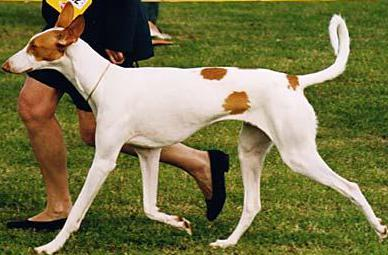

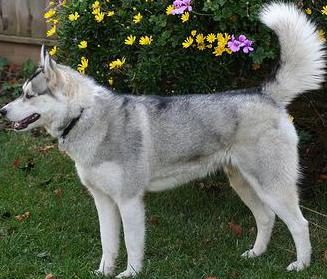

In [0]:
import IPython.display as display

for n in range(2):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print()

## Determines the label for each image

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [14, 38, 79, 17, 25, 41, 109, 118, 92, 88]


## Load and format the images

In [0]:
import re

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

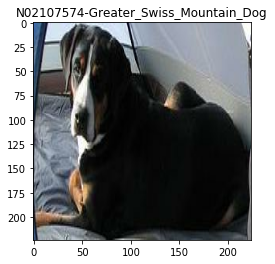

In [0]:
import matplotlib.pyplot as plt

random_index = random.choice(range(image_count))

image_path = all_image_paths[random_index]
label = all_image_labels[random_index]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

## A dataset of ```(image, label)``` pairs

In [0]:
valid_ratio = 0.05
test_ratio = 0.05

num_valid = int(image_count * valid_ratio)
num_test = int(image_count * test_ratio)
num_train = image_count - num_valid - num_test

train_paths = all_image_paths[ : num_train]
train_labels = all_image_labels[ : num_train]

valid_paths = all_image_paths[num_train : -num_test]
valid_labels = all_image_labels[num_train : -num_test]

test_paths = all_image_paths[-num_test : ]
test_labels = all_image_labels[-num_test : ]

In [0]:
len(train_paths), len(valid_paths), len(test_paths)

(18522, 1029, 1029)

In [0]:
ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
ds_valid = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

ds_train = ds_train.map(load_and_preprocess_from_path_label)
ds_valid = ds_valid.map(load_and_preprocess_from_path_label)
ds_test = ds_test.map(load_and_preprocess_from_path_label)

## Basic methods for training
* To be well shuffled
* To be batched
* To repeat forever
* Batched to be available as soon as possible


In [0]:
BATCH_SIZE = 32

# ds_train = ds_train.cache() # cache
ds_train = ds_train.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=num_train))
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_train

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [0]:
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [0]:
ds_test = ds_test.batch(BATCH_SIZE)
ds_test

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [0]:
import gc
gc.collect()

2263

## Pipe the dataset to a model

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    weights='imagenet')
logits = keras.layers.Dense(120, 'softmax')(model.layers[-1].output)
model = keras.models.Model(model.inputs, logits)
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model.summary()

17227776/17225924 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________________________________

In [0]:
len(model.trainable_variables)

83

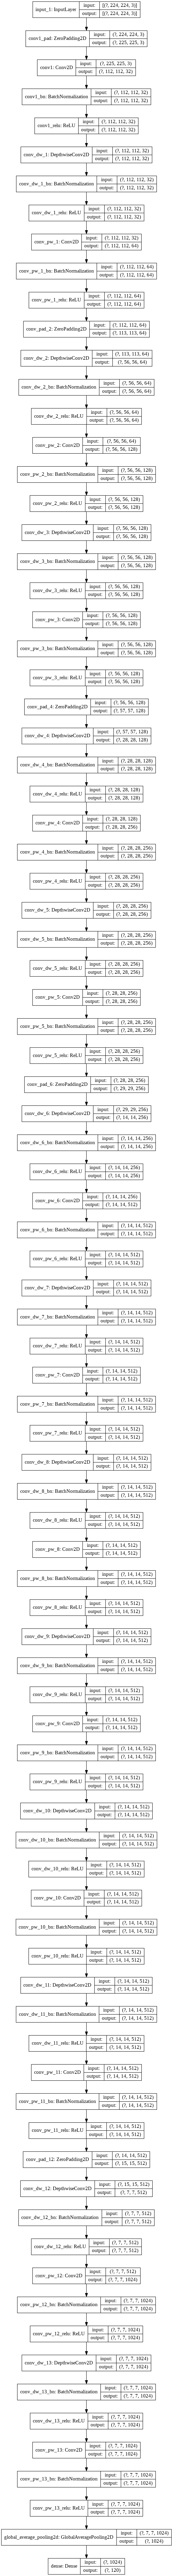

In [0]:
keras.utils.plot_model(model, 'InceptioinV3.png', show_shapes=True)

In [0]:
steps_per_epoch=tf.math.ceil(num_train/BATCH_SIZE).numpy()
steps_per_epoch

579.0

In [0]:
model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch, validation_data = ds_valid)

Train for 579.0 steps, validate for 33 steps
Epoch 1/10


RAM exploded : .fit() => .fit_generator()
fit() 은 모든 데이터를 한번에 올려서 학습을 진행하기 때문.

In [0]:
model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch, validation_data = ds_valid)

In [0]:
model.evaluate(ds_test)